In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# os permettera de calculer le nombre de fichier et de changer de dossiers dynamiquement
import os

# pour transformer des str data en objet datetime
import datetime as dt

# utilisé à plusieurs fins
import math
import time
import random

# Permet d'importer des données à partir du web
import pandas_datareader as web

# Permet des tests statistiques permettant d'évaluer notre modèle
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats import diagnostic as diag

from scipy import stats as stt
import pylab

# test d'autocorrelation
from statsmodels.stats.stattools import durbin_watson

# Permet d'effectuer une regression multiple, ainsi que des prédictions graces au processus ML train/test
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import requests
import json

# pip install XlsxWriter
import xlsxwriter

from urllib.request import urlopen
from bs4 import BeautifulSoup


from fredapi import Fred
fred = Fred(api_key='c9fa6f012c9ea24190b41703d64f6d08')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

# Créateur de rapports

Cette fonction construit des petits rapports excel à l'aide de xlsx writer si l'utilisateur désire enregistrer les résultats de son calcul

In [2]:
def créerRapport(direction, stats, allocation):
    
    # utilisé pour retourner le dossier mère des données à l'utilisateur
    PATH = f'STOCKS/{créerPath(direction)}/'
    
    # toutes les opérations de création de fichier se produiront dans le dossier RAPPORTS
    os.chdir('RAPPORTS')
    
    # pour éviter que les fichiers aient le même nom (suppression automatique)
    liste_verif = os.listdir()
    code = 1
    rapport = "Rapport_"+str(code)+".xlsx"
    while rapport in liste_verif:
        code += 1
        rapport = "Rapport_"+str(code)+".xlsx"

    # création d'un objet Workbook (un fichier excel vide)
    workbook = xlsxwriter.Workbook(rapport)
    
    # création de l'onglet Mes Résultats
    worksheet = workbook.add_worksheet("Mes résultats")
    
    # formatting rapide pour que les colonnes A, B & D soient plus larges
    worksheet.set_column('A:B', 28)
    worksheet.set_column('D:D', 32)
    
    # tuple de listes avec les statistiques obtenues 
    statistiques = (
        ['Écart-Type', stats[1]],
        ['Rendement', stats[0]],
    )
    
    # À la colone A:B nous avons le lieu de nos données
    worksheet.write(0, 0, "Pour les fichier du dossier ")
    worksheet.write(0, 1, PATH)
    worksheet.write(1,0, "Créé le " + str(dt.datetime.now()))
    
    # Rappel du rendement souhaité par l'utilisateur
    worksheet.write(2,1, "Vous avez choisi un rendement de ")
    worksheet.write(2,2, stats[0])
    
    worksheet.write(4, 1, "Statistiques")
    # où le tableau affichant les statistiques vas commencer 
    row = 5
    col = 1
    # itération du tuple statistiques
    for stat, rés in (statistiques):
        worksheet.write(row, col, stat)
        worksheet.write(row, col + 1, rés)
        row += 1
    row += 1
    
    worksheet.write(row, col, "Poids")
    row += 1
    # tableau afficant les poids
    for stock in allocation.columns:
        worksheet.write(row, col, stock)
        worksheet.write(row, col+1, allocation.loc["pct"][stock])
        lien = f"https://finance.yahoo.com/quote/{stock}"
        worksheet.write(row, col+2, lien)
        row += 1
        
    # petit message pour que utilisateurs sachent où trouver le fichier
    print("Allez voir {}".format(os.getcwd()+'/'+rapport))
    
    # pour finaliser l'enregistrement du fichier
    workbook.close()
    
    # retour en arrière (dans le dossier PROJET)
    os.chdir('../')


# Créateur de path (lieu où trouver les fichiers)

In [3]:
def créerPath(direction):
    
    dict_direction = {'1': "ALIMENTAIRE",
                  '2': "COMMODITÉS",
                  '3': "CONSOMMATION", 
                  '4': "ÉNERGIE",
                  '5': "FINANCE",
                  '6': "TECHNOLOGIE"}
    
    return dict_direction[direction]

# Téléchargeur de données

In [4]:
def téléchargerDf(direction):
    
    PATH = f'STOCKS/{créerPath(direction)}/'
    
    # génère une liste avec les index qu'il ne faut pas inclure
    index_à_éviter = pd.read_csv('index.csv', sep = ";").loc[0].values.tolist()
    index_à_éviter = [index_à_éviter[i].replace(".", "_") for i in range(len(index_à_éviter))]
    
    # génère une liste avec le nom de chaque actions
    stock_list = os.listdir(PATH)
    
    stock_list = [stock_list[i].replace('.csv','') for i in range(len(stock_list))]
    
    for i, stock in enumerate(stock_list):
        if stock in index_à_éviter:
            del stock_list[i]
        elif stock == '.DS_Store':
            del stock_list[i]

    # initialisation d'un dictionnaire où seront stockés les DataFrames
    dict_stocks = {i: None for i in stock_list}

    nb_actions = 15
    count = 1
    # création des DataFrame
    for i in stock_list:
        # création des DataFrame
        dict_stocks[i] = pd.read_csv(f'{PATH}{i}.csv')

        # pour garder un échantillon élevé nous conservons seulement
        # les DataFrames qui ont 1260 jours soit depuis février 2017
        try:
            if len(dict_stocks[i]) != 1260:
                del dict_stocks[i]
                count -=1
        except:
            del dict_stocks[i]
            count -=1
        
        if count == nb_actions:
            break
        count+=1
        
    stock_list = [i for i in dict_stocks]
    for i in stock_list:
        if dict_stocks[i] is None :
            del dict_stocks[i]
    
    return dict_stocks

# Créateur de colones de rendement

In [5]:
def créerRendement(dict_stocks):
    # fonction qui retourne un data frame rendement
    def rendement(df):
        df['daily_return'] = (df['Close'] / df['Close'].shift(1))-1
        return df  
    
    # fonction qui retourne un data frame du rendement cumulatif
    def rendementCumul(df):
        df['cum_return'] = (1+df['daily_return']).cumprod()
        return df
    
    for i in dict_stocks:
        dict_stocks[i] = rendement(dict_stocks[i])
        dict_stocks[i] = rendementCumul(dict_stocks[i])
    return dict_stocks

# Matrice des covariances

Voici tous les opérations que nous devrons reproduire:
<img src='IMAGES/variance.png' width="400" height="400">

                        source: Cours de programmation de modèles quantitatifs en finance

In [6]:
def créerMatCovar(dict_stocks):
    # première opérations consiste à soustraire de chaque rendement la moyenne des rendements
    df_var = pd.DataFrame()

    for i in dict_stocks:
        # soustractions avec conditions try pour éviter les érreurs
        try:
            df_var[i] = dict_stocks[i].loc[:]['daily_return'] - dict_stocks[i].loc[:]['daily_return'].mean()
        except:
            pass
        
    # le rendement de la première journée ne peux être calculé donc ces valeurs sont ignorées
    df_var = df_var.loc[1:]

    # utilisation des arrays de numpy qui permettent de faire des calculs matriciels
    mat_var = df_var.to_numpy()

    mat_covar = 1/len(mat_var)*np.matmul(np.transpose(mat_var),mat_var)
    
    return mat_covar



# Optimisation

Voici le modèle d'optimisation qui nous permettera de minimiser la variance du portfolio:
<img src='IMAGES/optimisation.png' width="200" height="400">


                     
<img src='IMAGES/Optimisation_matrice.png' width="800" height="400">

                    source: cours de programmation de modèles quantitatifs en finance

______________
__Condition 1: le produit matriciel entre les poids et les rendements, doivent être égaux au rendement désiré__

__Condition 2: le produit matriciel entre e et les poids doivent être égaux à 1, donc tous l'argent dans notre portfolio doit être utilisé__

__En somme, nous devons trouver un scalaire x qui minimise la variance de notre portefeuille__
______________
_x: Vecteur des poids de chaque actifs_

_S: Matrice des covariances "mat_covar"_

_r: Vecteur des rendements de chaque actifs_

_rpf: Scalaire représentant le rendement désiré_

_e: Vecteur [1, 1, 1, ..., 1]_

In [7]:
def vecR(dict_stocks):
    r = []
    for i in dict_stocks:
        # soustractions avec conditions try pour éviter les érreurs
        try:
            # itération dans les DataFrames pour trouver le rendement moyen de chaque action
            # puis on le rajoute à la liste r (ne pas utiliser les index 0 puisque == NaN)
            r.append(dict_stocks[i].loc[1:]['daily_return'].mean())
        except:
            pass

    # transformation de la liste r en numpy array (vecteur)
    vec_r = np.array([r])
    
    return vec_r

# liste des rendements
def créerMatCovarAugmentée(mat_covar, vec_r, dict_stocks):

    # création d'une liste contenant n fois 1 (n étant le nombre d'actions)
    e = [1 for i in range(len(mat_covar))]

    # transformation de la liste e en numpy array (vecteur)
    vec_e = np.array(e)

    # concatenation entre la matrice des covariances et les vecteurs r et e transposé
    # axis = 1 dit à numpy de de rajouter "r" et "e" en tant que colonnes (à la fin)
    mat_covar_aug = np.concatenate((mat_covar, np.transpose(vec_r)), axis = 1)
    mat_covar_aug = np.concatenate((mat_covar_aug, np.transpose([vec_e])), axis = 1)


    # ceci permet de savoir combien de 0 il faut rajouter aux deux vecteurs r et e
    # comme pour le côté inférieur droit de la matrice des covariances augmentés (voir image en haut)
    zero_to_append = len(mat_covar_aug[0])-len(dict_stocks)

    vec_r_aug = vec_r
    vec_e_aug = vec_e

    # itération de "zero_to_append" et rajout des "0" aux deux vecteurs
    for i in range(zero_to_append):
        vec_r_aug = np.append(vec_r_aug,0)
        vec_e_aug = np.append(vec_e_aug,0)

    # concatenation entre la matrice des covariances et les vecteurs r et e
    # axis = 0 dit à numpy de de rajouter "r" et "e" en tant que lignes (à la fin)
    mat_covar_aug = np.concatenate((mat_covar_aug, [vec_r_aug]), axis = 0)
    mat_covar_aug = np.concatenate((mat_covar_aug, [vec_e_aug]), axis = 0)
    
    return mat_covar_aug


# Ici il faudra inscrire le rendement désiré

In [8]:
# fonction qui prends une rendement spécifique
# et qui le transforme en rendement continu journalier
def convRendement(rend):
    
    # rendement_continu = ln(1+r/période)
    if rend[0] == '.':
        rend = '0' + rend
    
    if rend[-1] == "a":
        rend = math.log(1+float(rend[:-1])/252)
    elif rend[-1] == "m":
        rend = math.log(1+float(rend[:-1])/30)
    elif rend[-1] == "j":
        rend = math.log(1+float(rend[:-1]))
        
    # pour retourner une valeur prédéfinie
    elif rend == "p":
        rend = math.log(1+0.001)
    
    # si le rendement est inadéquat retourne une erreur
    else:
        raise TypeError('Vous devez rajouter un "a", "m" ou "j" à la fin du rendement')
        
    if rend < 0:
        raise ValueError('Vous devez rajouter une valeur supérieure à 0%')

    return rend

def créerVecCond(mat_covar_aug, rendement):
    rendement_continu = convRendement(rendement)

    # création du vecteur des valeurs des conditions de la même taille de les vecteurs r et e
    cond = [0 for i in range(len(mat_covar_aug)-2)]

    # rajout des valeurs des deux contraintes "rpf" et 1
    cond.extend([rendement_continu, 1])

    # transformation en numpy.array
    vec_cond = np.array([cond])

    return vec_cond

In [9]:
def créerVecPoids(mat_covar_aug, vec_cond):
    # calcul de l'inverse de la matrice des covariances augmentée
    mat_covar_aug_inv = np.linalg.inv(mat_covar_aug)

    # multiplication entre l'inverse de la matrice des covariances augmentée
    # et le vecteur des conditions (ceci retourne le vecteur recherché)
    vec_rech = np.matmul(mat_covar_aug_inv,np.transpose(vec_cond))

    # le vecteur recherché contient des valeurs pour chaque condition 
    # (celle-ci ne sont pas importantes) nous voulons seulement les poids
    vec_poids = np.transpose(vec_rech[:-2])

    return vec_poids

# Formules pour trouver les statistiques du portfolio

<img src='IMAGES/Formules.png' width="800" height="400">

In [10]:
def produireStats(direction, rendement):
    
    dict_stocks = téléchargerDf(direction)
    
    dict_stocks = créerRendement(dict_stocks)
    mat_covar = créerMatCovar(dict_stocks)

    vec_r = vecR(dict_stocks)

    mat_covar_aug = créerMatCovarAugmentée(mat_covar, vec_r, dict_stocks)
    
    vec_cond = créerVecCond(mat_covar_aug, rendement)
    
    vec_poids = créerVecPoids(mat_covar_aug, vec_cond)
    
    # rendement du portfolio trouvé en multipliant le vecteur des poids au vecteur des rendements
    rendement_portfolio = np.matmul(vec_r, np.transpose(vec_poids))[0][0]

    # variance du portfolio trouvé en multipliant le vecteur des poids
    # à la matrice des covariances puis encore par le vecteur des poids
    variance_portfolio = np.matmul(np.matmul(vec_poids, mat_covar), np.transpose(vec_poids))[0][0]

    # écart-type est la racine de la variance
    écart_type_portfolio = math.sqrt(variance_portfolio)

    return (rendement_portfolio, écart_type_portfolio)

In [11]:
def produirePoids(direction, rendement):
    
    dict_stocks = téléchargerDf(direction)
    
    dict_stocks = créerRendement(dict_stocks)
    
    mat_covar = créerMatCovar(dict_stocks)

    vec_r = vecR(dict_stocks)

    mat_covar_aug = créerMatCovarAugmentée(mat_covar, vec_r, dict_stocks)
    
    vec_cond = créerVecCond(mat_covar_aug, rendement)
    
    vec_poids = créerVecPoids(mat_covar_aug, vec_cond)
    
    liste_poids = [i for i in vec_poids[0]]

    # DataFrame des poids
    liste_stocks = [i for i in dict_stocks]
    df_poids = pd.DataFrame(liste_poids, columns = ["pct"], index=liste_stocks).transpose()
    
    return df_poids

# Les fonctions en bref

produireStats retourne un tuple avec comme premier argument le rendement, et comme deuxième argument l'écart-type

produirePoids retourne un DataFrame contenant le pourcentage d'allocation pour chacunes des actions (noter qu'un poids négatif signifie une vente à découvert)

# Question principale

# Quelle allocation entre plusieurs actions permettrais de minimiser la volatilité pour un rendement désiré?

In [ ]:
print("###1: Alimentaire, 2: Commodités, 3: Consommation, 4: Énergie, 5: Finance, 6: Technologie###")

#pour que le input arrive après le print
time.sleep(0.5)

direction = input("Veuillez inscrire le nombre associé au secteur désiré: ")

# seules valeurs possibles
val_poss = [str(i) for i in range(1,7)]

# si le input "direction" n'est pas possible
if direction not in val_poss:
    raise ValueError('Attention le chiffre inséré doit être entre 1 et 6')
    
print("merci!\n"+"_"*100)

print("\n###Veuillez insérer le rendement nominal désiré, puis la periode de ce rendement###\n")
print("\t\t a = annuel, m = mensuel, j = journalier\n")
print("### Ex 0.07a (donc rendement de 7% annuel) | 0.0003j (donc rendement de 0.03% journalier) ###\n")
print('\t\t\t si vous voulez un rendement préselectionné, veuillez écrire p\n')

rendement = input("Rendement désiré ainsi que la période: ")

print("merci!\n"+"_"*100)

# tuple contenant le rendement puis l'écart-type
stats = produireStats(direction, rendement)

# dataframe avec les poids que le modèle a trouvé
allocation = produirePoids(direction, rendement)

# mettre le rendement ainsi que l'écart-type en pct
rendement_pct = round(stats[0]*100,4)
ét_pct = round(stats[1]*100,4)

print(f"\nUne allocation comme celle-ci : \n{allocation}\n")
print(f"vous permettera d'avoir un écart-type minimal de {ét_pct}% par jour pour un rendement de {rendement_pct}% par jour\n")

somme = 0
# interrupteur si il existe un poids négatif
verif = False
for i in allocation.iloc[0]:
    # si on trouve un premier poids négatif
    if i < 0 and verif is False:
        print(f"Cette stratégie nécessite de vendre à découvert ", end ='')
        # activer interrupteur
        verif = True
    # compter le nombre de poids négatifs    
    if i < 0 and verif is True:
        somme += 1

# fin du statement print indiquant le nombre d'actions à poids négatif
if verif is True:    
    print(f'{somme} actions \n')
    
print("Voulez-vous créer un rapport ?", '\033[1m' + '*Attention ceci va créer un fichier excel* ' + '\033[0m', ': ')
rép = input('[1=oui] [0=non] : ')
# si la réponse est 1 créer un rapport
if rép == "1":
    créerRapport(direction, stats, allocation)

###1: Alimentaire, 2: Commodités, 3: Consommation, 4: Énergie, 5: Finance, 6: Technologie###
Veuillez inscrire le nombre associé au secteur désiré: 6
merci!
____________________________________________________________________________________________________

###Veuillez insérer le rendement nominal désiré, puis la periode de ce rendement###

		 a = annuel, m = mensuel, j = journalier

### Ex 0.07a (donc rendement de 7% annuel) | 0.0003j (donc rendement de 0.03% journalier) ###

			 si vous voulez un rendement préselectionné, veuillez écrire p

Rendement désiré ainsi que la période: p
merci!
____________________________________________________________________________________________________

Une allocation comme celle-ci : 
         DTE       APH       LNT       KEP       EDN       ETR      KODK  \
pct  0.26013  0.334547  0.288128 -0.022372  0.005246 -0.005485  0.012081   

         AMZN       GLW        ED       CMS        SO       PCG      PNW  \
pct  0.283818 -0.138586  0.182238  0.2

# Questions secondaires

# Quel rendement minimise l'écart-type?
#### Utilisation de la théorie de frontière effciente, dévelopée par Harry Markowitz en 1952, afin d'évaluer l'efficacité de la stratégie d'investissement de l'utilisateur

La configuration de portefeuille créée plus haut a été modelée selon les informations entrées par l'utilisateur, soit le secteur d'affaires et le rendement désiré. Cependant, cette configuration est-elle réellement optimale?

La théorie moderne de portefeuille se base sur le constat que la majorité des investisseurs sont averses au risque. Parfois, ils préféreront accepter un rendement de portefeuille moins élevé afin de diminuer le risque financier auquel ils s'exposent.

En finance, une frontière efficiente regroupe l'ensemble des combinaisons d'actifs financiers présentant le meilleur rendement pour un niveau de risque donné. Mesuré par l'écart-type du portefeuille, ce niveau de risque est également synonyme de volatilité. Le portefeuille affichant l'écart-type le moins élevé sur la frontière efficiente porte le statut de portefeuille optimal. Voici un exemple d'une frontière efficiente: 
<img src='IMAGES/Frontiere_efficiente.png' width="500" height="400">

Dans cette section, nous utiliserons la théorie moderne de portefeuille afin de guider l'utilisateur dans sa stratégie d'investissement. Ceci impliquera d'afficher une frontière efficiente sur laquelle seront comparés le portefeuille optimal pour un investisseur averse au risque et le portefeuille actuel de l'utilisateur. Dans le cas où celui-ci perçoit que son portefeuille actuel est plus volatile que le portefeuille optimal, il pourra amener des modifications au rendement qu'il est prêt à accepter.

In [180]:
# création d'un dictionnaire qui nous permettra d'avoir une idée du rendement général d'une industrie
dict_stock = créerRendement(téléchargerDf(direction))

somme = 0
# loop qui crée une moyenne du rendement cumulatif des actions du portfolio sur une durée de 5 ans
for stock in dict_stock:
    somme += dict_stock[stock]['cum_return'].iloc[-1]
    moyenne = (somme/len(dict_stock))
    
# retour sur une composition annuelle (5ans => 1 an)
moyenne = (moyenne)**(1/5)-1

# le range de notre axe des y
rendement_esp = np.arange(0, max((1+stats[0])**365-1, moyenne)+0.2, 0.008)
        
# Convertir le array 'rendement_esp' en liste à l'aide de 'tolist()' afin d'itérer sur celle-ci plus tard
rend_esp_list = rendement_esp.tolist()

# Créer un dictionnaire vide où on stockera des couples de type 'Rendement' : 'Écart-type'
eff_front_list = []

# À l'aide de la fonction défénie plus tôt 'produireStats', générer des tuples (rendement, écart-type) pour chaque
# rendement de la liste 'rend_esp_list'
# Chaque tuple sera un élément de la liste 'eff_front_list'
for rend in rend_esp_list:
    eff_tuple = produireStats(direction, str(rend) + "a")
    eff_front_list.append(eff_tuple)
    

# Créer un DF où on stockera les tuples
eff_front_df = pd.DataFrame(columns = ["Rendement", "Écart-type"])

# Remplir le DF avec les informations nécessaires
for i, couple in enumerate(eff_front_list):
    eff_front_df.loc[i, "Rendement"] = float(couple[0])
    eff_front_df.loc[i, "Écart-type"] = float(couple[1])
    
eff_front_df.head()

,Rendement,Écart-type
0,-0.0,0.012367
1,0.000032,0.0122
2,0.000063,0.01204
3,0.000095,0.011888
4,0.000127,0.011745


In [181]:
# Trouver les coordonnées du prtefeuille avec le plus petit écart-type - Le meilleur ratio rendement/risque
# Nous utiliserons ces coordonnées pour comparer le portefeuille calculer pour l'utilisateur avec le portefeuille le moins
# risqué sur la frontière efficiente
min_risk = eff_front_df["Écart-type"].min()

for i in range(len(eff_front_list)):
    if eff_front_list[i][1] == min_risk:
        opt_return = eff_front_list[i][0]

# Afficher les données (coordonnées) du portefeuille optimal
print("Voici le rendement et l'écart-type du portefeuille qui minimise l'écart-type dans le secteur '{0}':\n".format(créerPath(direction)))
print("Écart-type (volatilité): {0}%".format(min_risk * 100))
print("Rendement (journalier): {0}%".format(opt_return * 100))

Voici le rendement et l'écart-type du portefeuille qui minimise l'écart-type dans le secteur 'TECHNOLOGIE':

Écart-type (volatilité): 1.0766997652447576%
Rendement (journalier): 0.053953696343508266%


<module 'matplotlib.pyplot' from '/Users/felix/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

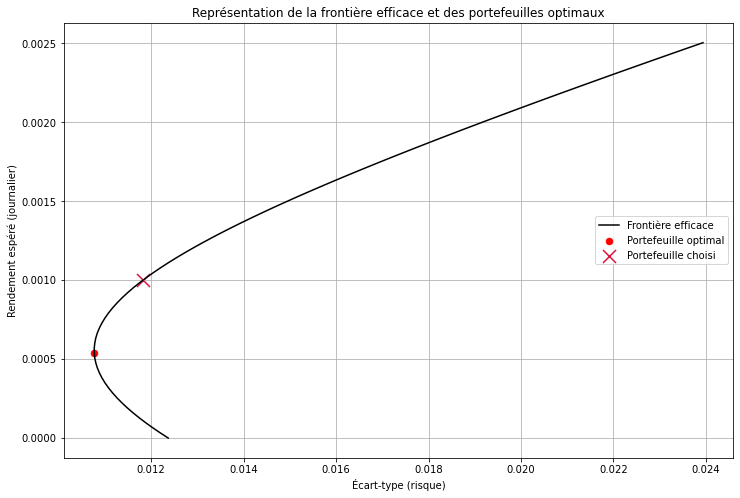

In [182]:
# Créer la frontière efficace de hauteur 8 et de largeur 12
plt.rcParams["figure.figsize"] = (12,8)

# Utilser la fonction 'plot' de matplotlib avec les données du DF 'eff_front_graph'
eff_front_graph = eff_front_df.plot(kind = "line", x = "Écart-type", y = "Rendement", color = "black")

# Marquer le point sur la frontière qui correspond au portefeuille optimal
plt.scatter(min_risk, opt_return, color = "red", s = 170, marker = ".")

# Marquer le point sur la frontière qui correspond au portefeuille généré par le système
plt.scatter(stats[1], stats[0], color = "crimson", s = 170, marker = "x" )

# Mettre un quadrillage sur graphique
plt.grid(True)

# Donner des titres aux axes et un titre au graphique
plt.xlabel("Écart-type (risque)")
plt.ylabel("Rendement espéré (journalier)")
plt.title("Représentation de la frontière efficace et des portefeuilles optimaux")
plt.legend(["Frontière efficace","Portefeuille optimal", "Portefeuille choisi"], loc = "center right")
# Afficher le graphique
display(plt)

# Quelle est la performance du portefeuille contre un index comparable?

Une façon d'évaluer la performance du portefeuille de l'utilisateur est de le comparer à un index économique du même secteur d'activités. Dans cette optique, nous avons sélectionné 1 index économique par secteur afin de donner une idée à l'utilisateur de la qualité du portefeuille qu'il a en mains. Ces 6 index sont:
- Alimentaire: iShares Global Agriculture Index ETF (COW.TO)
- Commodités: Vanguard Utilities Index Fund (VPU)
- Consommation: SPDR S&P Retail ETF (XRT)
- Énergie: S&P 500 Energy (^GSPE)
- Finance: SPDR S&P Regional Banking ETF (KRE)
- Technologie: S&P 500 Information Technology (^SP500-45)

Les objectifs de cette section sont:
1. De calculer le ratio Sharpe du portefeuille. En somme, ce ratio calcule le retour du portefeuille en fonction de son risque. Ceci nous permettra de quantifier la performance globale du portefeuille. Un bon Sharpe est supérieur à 1. Voici la formule utilisée pour le calcul du ratio Sharpe: <img src='IMAGES/Sharpe.png' width="400" height="400">

2. De calculer le ratio Traynor du portefeuille. Essentiellement, ce ratio calcule le retour du portefeuille en fonction de son beta. Ceci nous permettra de quantifier la performance globale du portefeuille ajusté pour l'industrie. Un bon Sharpe est supérieur à 0. Voici la formule utilisée pour le calcul du ratio Treynor: <img src='IMAGES/Treynor.png' width="400" height="400">

3. De calculer l'alpha du portefeuille. L'alpha d'un portefeuille mesure la performance de celui-ci contre un index représentant son secteur d'activités. Cet index sert donc de "benchmark" pour ce marché. Plus simplement, l'alpha nous permet d'observer la position d'un portefeuille par rapport à un marché quelconque. L'objectif d'un investisseur est donc de détenir un portefeuille qui a une performace globale supérieure à celle du marché, et dans ce cas-ci, à celle de l'index. Voici la formule utilisée pour le calcul de l'alpha: <img src='IMAGES/Alpha.png' width="200" height="200">


4. D'afficher un graphique en ligne montrant l'évolution du rendement cumulatif de notre portefeuille et du rendement cumulatif de l'index sur une échelle temporelle de 5 ans. Ce graphique devrait avoir une allure similaire à l'image suivante:
<img src='IMAGES/Graph.png' width="600" height="600">

In [183]:
# dictionnaire contenant les "index", pour pouvoir les retrouver dans les dossiers
dict_direction = {"ALIMENTAIRE":"COW_TO",
                  "COMMODITÉS":"VPU",
                  "CONSOMMATION":"XRT", 
                  "ÉNERGIE":"^GSPE",
                  "FINANCE":"KRE",
                  "TECHNOLOGIE":"^SP500-45"}

# lecture du fichier en DataFrame
index = pd.read_csv('STOCKS/'+créerPath(direction)+'/'+dict_direction[créerPath(direction)]+'.csv', sep = ',')

# la fonction créer rendement requiert un dictionnaire
dict_index = {dict_direction[créerPath(direction)] : index}

index = créerRendement(dict_index)[dict_direction[créerPath(direction)]]

# comparaison des résultats de notre portefeuille et des résultats de notre index (pas ajusté pour le risque)
print("\tComparaison non ajustée pour le risque")
print(f"INDEX: rendement: {round(index.loc[:]['daily_return'].mean(),6)}, écart-type: {round(index.loc[:]['daily_return'].std(),6)}")
print(f"PORTEFEUILLE: rendement: {round(produireStats(direction, rendement)[0],6)}, écart-type: {round(produireStats(direction, rendement)[1],6)}")


	Comparaison non ajustée pour le risque
INDEX: rendement: 0.001028, écart-type: 0.016162
PORTEFEUILLE: rendement: 0.001, écart-type: 0.011817


In [184]:
# Ajouter les colonnes 'daily_return' et 'cum_return' avec la fonction 'créerRendement'
index_df = créerRendement(dict_index)[dict_direction[créerPath(direction)]]
    
# Tranformer le type de la colonne 'Date' en datetime64
index_df["Date"] = pd.to_datetime(index_df["Date"])
    
# Mettre la colonne de date du DF 'index_df' en index
index_df = index_df.set_index("Date")

# Seulement conserver la colonne 'daily_return' du DF 'index_df' (On exclut la première ligne de NaN avec iloc[1:])
index_series = index_df.loc[:]['daily_return'].iloc[1:]

# Mettre la Series 'index_series' dans un DataFrame appelé 'comparative_df'
comparative_df = pd.DataFrame({dict_direction[créerPath(direction)] : index_series})

In [185]:
compteur = 0

daily_ret_df = pd.DataFrame()
# Itérer sur les titres du portefeuille qui sont les clés dans 'dict_stock'
for title in dict_stock:
    daily_ret_df[title] = dict_stock[title]['daily_return'].loc[1:]
    while compteur == 0:
        daily_ret_df["Date"] = dict_stock[title]["Date"].loc[1:]
        compteur = compteur + 1

# Transformer le type de la colonne "Date" en datetime64
daily_ret_df["Date"] = pd.to_datetime(daily_ret_df["Date"])

# Mettre la colonne de date en index       
daily_ret_df = daily_ret_df.set_index("Date")

# rejoindre les données selon leur date pour s'assurer que le calcul soit bon
comparative_df_2 = comparative_df.join(daily_ret_df, on = "Date")

# pour s'assurer que les dates manquantes sont supprimées
comparative_df_2.dropna().tail()

,^SP500-45,DTE,APH,LNT,KEP,EDN,ETR,KODK,AMZN,GLW,ED,CMS,SO,PCG,PNW,BKH
Date,,,,,,,,,,,,,,,,
2022-03-28,0.012293,-0.001155,0.001850,0.002749,0.007423,0.018293,0.004441,0.054878,0.025593,-0.010946,0.003992,0.002902,0.000987,0.005008,0.009739,0.003360
2022-03-29,0.020629,0.006862,0.020446,0.003226,-0.006316,-0.002994,0.008930,0.013006,0.001920,0.009750,0.005051,0.004196,0.014930,-0.002492,0.010949,0.014601
2022-03-30,-0.013625,0.015085,-0.008402,0.010932,-0.004237,0.031532,0.005757,-0.028531,-0.017801,-0.019311,0.012938,0.008356,0.006106,0.006661,0.001676,0.013203
2022-03-31,-0.015930,-0.002640,-0.017729,-0.006361,-0.009574,-0.018923,-0.002478,-0.038179,-0.019865,-0.017829,-0.000528,-0.000714,0.000138,-0.012407,0.005277,0.003649
2022-04-01,-0.001657,0.020649,0.002920,0.012964,0.011815,0.037092,0.028608,-0.039695,0.003451,-0.014901,0.015104,0.016586,0.022204,0.027638,0.015621,0.018437


,^SP500-45,DTE,APH,LNT,KEP,EDN,ETR,KODK,AMZN,GLW,ED,CMS,SO,PCG,PNW,BKH
^SP500-45,1.000000,0.434461,0.771071,0.376583,0.362512,0.196901,0.430558,0.107672,0.702589,0.682221,0.292698,0.361059,0.404580,0.204925,0.383567,0.436369
DTE,0.434461,1.000000,0.502843,0.747185,0.303008,0.143491,0.785210,0.045713,0.146594,0.449822,0.620913,0.735672,0.706406,0.291762,0.804228,0.781475
APH,0.771071,0.502843,1.000000,0.388065,0.367395,0.214097,0.455220,0.102129,0.447015,0.741199,0.304583,0.355010,0.419820,0.245518,0.432094,0.495859
LNT,0.376583,0.747185,0.388065,1.000000,0.267786,0.054291,0.832571,0.027209,0.131497,0.379903,0.822445,0.903455,0.834095,0.245475,0.788650,0.758100
KEP,0.362512,0.303008,0.367395,0.267786,1.000000,0.105472,0.300314,0.061278,0.212016,0.329219,0.224919,0.254810,0.289228,0.118391,0.318146,0.334300
EDN,0.196901,0.143491,0.214097,0.054291,0.105472,1.000000,0.109831,0.035852,0.118764,0.180673,0.030424,0.039821,0.089469,0.064007,0.110278,0.124768
ETR,0.430558,0.785210,0.455220,0.832571,0.300314,0.109831,1.000000,0.047324,0.156104,0.420727,0.739369,0.822351,0.812483,0.275037,0.817638,0.797648
KODK,0.107672,0.045713,0.102129,0.027209,0.061278,0.035852,0.047324,1.000000,0.067609,0.118018,0.018075,0.020516,0.031186,0.029277,0.043446,0.035694
AMZN,0.702589,0.146594,0.447015,0.131497,0.212016,0.118764,0.156104,0.067609,1.000000,0.374320,0.092977,0.150972,0.141306,0.116023,0.131089,0.140492
GLW,0.682221,0.449822,0.741199,0.379903,0.329219,0.180673,0.420727,0.118018,0.374320,1.000000,0.344194,0.369051,0.435299,0.205841,0.409582,0.444097


<AxesSubplot:>

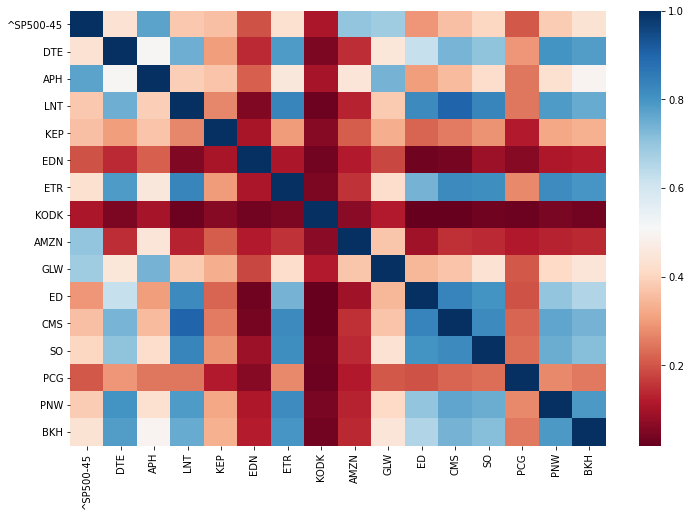

In [186]:
# Créer la matrice de corrélations
corr = comparative_df_2.corr()
display(corr)

#Heatmap pour la visualisation des corrélations
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, cmap='RdBu')

In [187]:
# Series contenant les écart-types seulement
std = comparative_df_2.describe().loc['std']

# Series contenant les corrélations vis à vis l'index seulement
corr = comparative_df_2.corr().loc[dict_direction[créerPath(direction)]]

beta_pf = 0

#iteration parmis les rangées pour calculer les betas des actions
for i in comparative_df_2.columns[1:]:
    # beta : ρ(i,x) * σx/σi
    beta = corr[i] * std[i] / std[0]
    
    # somme pondérée de beta
    beta_pf += beta * allocation.loc["pct"][i]

print(f"Le beta du portefeuille est {beta_pf}")


Le beta du portefeuille est 0.5180105096955788


In [188]:
# extraire le taux de rendement sur trésorerie américaine de 2 ans (taux sans risque)
# importe le html de la page web où se retrouve la valeur recherché
page = urlopen("https://www.marketwatch.com/investing/Bond/TMUBMUSD02Y?countryCode=BX").read()

# création d'un objet beautiful soup pour pouvoir manipuler le html
soup = BeautifulSoup(page, 'html.parser')

# lieu dans le html où se retrouve le taux sans risque
name_box = soup.find('h2', attrs={'class': 'intraday__price sup--right'})

# formatting de ce chiffre
taux_rf = name_box.text.strip() 
taux_rf = float(taux_rf.replace('%',''))/100

# convertir le taux annuel en taux journalier
taux_rf = (1+taux_rf)**(1/252)-1

print(f"Le taux sans risque journalier est {taux_rf}")

Le taux sans risque journalier est 9.539637663502631e-05


In [218]:
# calcul de alpha 
alpha = stats[0] - (taux_rf+beta_pf*(comparative_df.loc[:][dict_direction[créerPath(direction)]].mean()-taux_rf))

# calcul de Sharpe (converti en année)
sharpe = (stats[0]-taux_rf)/stats[1] * math.sqrt(252)

# calcul de Treynor (converti en année)
treynor = (stats[0]-taux_rf)/beta_pf * math.sqrt(252)

print("Sharpe ratio: notre portefeuille engendre un rendement d'un ratio de",'\033[1m' + f'{round(sharpe,2)}' + '\033[0m',
      "vis-à-vis le taux sans risque pour un même niveau de risque\n")

print("Treynor ratio: notre portefeuille engendre un rendement d'un ratio de",'\033[1m' + f'{round(treynor,2)}' + '\033[0m',
      "vis-à-vis le taux sans risque ajusté pour le beta vis-à-vis l'index\n")

print("Alpha: notre portefeuille engendre un rendement journalier de",'\033[1m' + f'{round(alpha*100,3)}' + '%\033[0m',
     "de plus que notre index ajusté pour le risque\n")

if alpha > 0 and sharpe > 1 and treynor > 0:
    print('Fantastique votre portfolio a un edge !')
elif alpha < 0:
    print("Votre portefeuille est performant mais pas assez, veuillez considérer d'autres actions")
    
elif sharpe < 1 or treynor < 0:
    print("Votre portefeuille est performant mais pas assez, veuillez considérer un meilleur secteur")
    
else:
    print("Malheureusement votre portefeuille n'a pas de edge, veuillez considérer d'autres actions ou une industrie plus performante")

Sharpe ratio: notre portefeuille engendre un rendement d'un ratio de 1.21 vis-à-vis le taux sans risque pour un même niveau de risque

Treynor ratio: notre portefeuille engendre un rendement d'un ratio de 0.03 vis-à-vis le taux sans risque ajusté pour le beta vis-à-vis l'index

Alpha: notre portefeuille engendre un rendement journalier de 0.042% de plus que notre index ajusté pour le risque

Fantastique votre portfolio a un edge !


In [190]:
# 1. Créer un DF avec les rendements cumulatifs de l'index

# Utiliser pd.read_csv() pour lire les données provenant du fichier CSV de l'index et les mettre dans un DataFrame
index_cum_df = pd.read_csv('STOCKS/'+créerPath(direction)+'/'+dict_direction[créerPath(direction)]+'.csv', sep = ',')

# Ajouter les colonnes 'daily_return' et 'cum_return' avec la fonction 'créerRendement'
index_cum_df = créerRendement(dict_index)[dict_direction[créerPath(direction)]]

# Tranformer le type de la colonne 'Date' en datetime64
index_cum_df["Date"] = pd.to_datetime(index_cum_df["Date"])

# Seulement conserver les colonnes 'cum_return' et "Date" du DF 'index_cum_df' 
# (On exclut la première ligne de NaN avec iloc[1:])
cumul_plot_df = pd.DataFrame(columns = ["Date", dict_direction[créerPath(direction)]])
cumul_plot_df["Date"] = index_cum_df.loc[:]["Date"].iloc[1:]
cumul_plot_df[dict_direction[créerPath(direction)]] = index_cum_df.loc[:]["cum_return"].iloc[1:]
# Mettre la date en index
cumul_plot_df = cumul_plot_df.set_index("Date")

In [191]:
# 2. Ajouter les rendements cumulatifs du portefeuille au DF 'cumul_plot_df'

# Suivre le même processus qui a été utilisé pour créer le DF daily_ret_df, mais avec la colonne "cum_return"
counter = 0

cum_ret_df = pd.DataFrame()
# Itérer sur les titres du portefeuille qui sont les clés dans 'dict_stock'
for title in allocation.columns:
    cum_ret_df[title] = dict_stock[title]['cum_return'].loc[1:]
    while counter == 0:
        cum_ret_df["Date"] = dict_stock[title]["Date"].loc[1:]
        counter = counter + 1

# Transformer le type de la colonne "Date" en datetime64
cum_ret_df["Date"] = pd.to_datetime(cum_ret_df["Date"])

# Retirer la colonne "Date" pour faciliter le calcul du rendement cumulatif pondéré du portefeuille (par jour)
portfolio_df = cum_ret_df.drop(columns = ["Date"])

# Ajouter une colonne appellée "Portefeuille" au DF 'portfolio_df' qui représentera 
# le rendement cumulatif (somme pondérée) du portefeuille (par jour)
portfolio_df["Portefeuille"] = 1.00000
for i in range(1, len(portfolio_df) + 1):
    somme_pond = 0
    for stock in allocation.columns:
        somme_pond += allocation.loc["pct"][stock] * portfolio_df.loc[i][stock]
    portfolio_df.at[i, "Portefeuille"] = somme_pond
    
# Ajouter la colonne "Portefeuille" du DF 'portfolio_df' au DF 'cum_ret_df'
cum_ret_df["Portefeuille"] = portfolio_df["Portefeuille"]
cum_ret_df = cum_ret_df.set_index("Date")

# Joindre un sous-ensemble du DF 'cum_ret_df' au DF 'cumul_plot_df' selon la colonne "Date"
cumul_plot_df_2 = cumul_plot_df.join(cum_ret_df[["Portefeuille"]], on = "Date")

# Enlever la ligne de NaN qui se retrouve à la dernière ligne de DF 'cumul_plot_df_2'
cumul_plot_df_2 = cumul_plot_df_2.dropna()

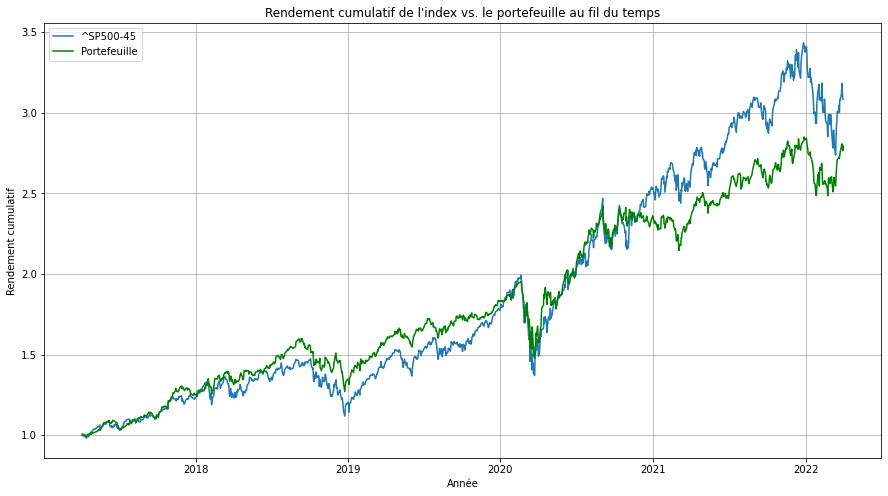

In [192]:
# Comparer l'évolution des rendments cumulatifs de l'index et du portefeuille sur un graphique

# Paramètres d'affichage du graphique
plt.rcParams["figure.figsize"] = (15,8)

# Ligne 1 : Rendement cumulatif de l'index
plt.plot(cumul_plot_df_2.index, cumul_plot_df_2[dict_direction[créerPath(direction)]])

# Ligne 2 : Rendement cumulatif du portefeuille
plt.plot(cumul_plot_df_2.index, cumul_plot_df_2["Portefeuille"], color = "green")

# Ajouter des étiquettes aux axes, un titre au graphique et une légende (VOUS POUVEZ LES CHANGER À DES NOMS PLUS APPROPRIÉS)
plt.xlabel("Année")
plt.ylabel("Rendement cumulatif")
plt.title("Rendement cumulatif de l'index vs. le portefeuille au fil du temps")
plt.legend([dict_direction[créerPath(direction)], "Portefeuille"], loc = "upper left")

# Ajouter un quadrillage au graphique
plt.grid(True)

# Afficher le graphique
plt.show()

# Quelles variables macroéconomiques affectent le plus fortement notre portfolio ?


Afin d’établir quelles sont les variables macroéconomiques qui affectent le plus notre portfolio, il faut effectuer une analyse de régression multiple qui décrira la variation du rendement cumulatif de notre portefeuille avec la variation de diverses variables économiques.

La démarche pour répondre à la question est donc la suivante:

1. Importer des séries de variables macroéconomiques à partir d’une source externe
2. Créer plusieurs tableaux d’analyse mettant en relation différentes variables macroéconomiques avec le rendement cumulatif de notre portefolio
3. Effectuer des analyses de régressions multiples à partir des tableaux d’analyses
4. Choisir le meilleur modèle de régression multiple et présenter les résultats.

<br>
<br>

## 1) Import des variables macroéconomiques

Les variables macroéconomiques vont être les variables explicatives de notre modèle. Nous importons des séries à partir de la base de données Fred (federal reserve economic data). Nous choisissons des séries qui ont des données quotidiennes afin de pouvoir comparer les variations avec le rendement journalier de notre portefeuille. Ces dernières sont importées à l’aide du module Pandas-Datareader, qui permet d’importer les séries directement en tant que DataFrame Pandas. L’api Fred est également utilisé, il nous permet de récupérer les titres des séries importées, afin de rendre la présentation des résultats plus claire. (Sans l’import des titres, se serait les ID de séries qui représenterait chacune de nos variables explicatives).

Les séries importées, nous les réunissons dans un même tableau, contenant toutes les variables économiques mise en rapport en fonction de leur date :

| Date     | Variable 1 | Variable 2 | ... | Variable n |
|----------|------------|------------|-----|------------|
| 01-02-20 | 08         | 23         | ... | 45         |
| 02-02-20 | 24         | 06         | ... | 47         |
| 03-02-20 | 02         | 23         | ... | 50         |
| 04-02-20 | 08         | 23         | ... | 45         |
| 05-02-20 | 24         | 06         | ... | 47         |
| 06-02-20 | 02         | 23         | ... | 50         |
| ...      | ...        | ...        | ... | ...        |

<br>
<br>
<br>

## 2) Création des tableaux d'analyses

Nous créons plusieurs tableaux d’analyse sur lesquelles des régressions multiples sont effectuées. Chacun de ces tableaux met en relation notre variable réponse avec des variables indépendantes.

Notre variable réponse, le Y du modèle,  est le rendement journalier de notre portefeuille. On obtient ce dernier en multipliant la matrice de poids calculée plus tôt dans le programme (question 1), avec le rendement cumulatif journalier des actions composant le portfolio. Cette variable dépendante est la même pour tous les tableaux d’analyse générés.

Nos variables explicatives, les X du modèles, sont des échantillons aléatoires de l'ensemble des variables macroéconomiques extraites lors de l’étape 1. Nous créons plusieurs tableaux mettant en relation notre Y avec différents X afin de voir laquelle des combinaisons de variables explicatives génère le meilleur modèle (nous développons ce que nous étendons par meilleur modèle dans l’étape 4)

Une fois cette étape terminé nous obtenons différents tableaux d’analyses de la forme suivante :

| Date     | Y   | X 1 | X 2 | ... | X n |
|----------|-----|-----|-----|-----|-----|
| 01-02-20 | 12  | 42  | 0   | ... | 78  |
| 02-02-20 | 15  | 34  | 8   | ... | 79  |
| 03-02-20 | 14  | 23  | 6   | ... | 82  |
| 04-02-20 | 12  | 42  | 0   | ... | 78  |
| 05-02-20 | 15  | 34  | 8   | ... | 79  |
| 06-02-20 | 14  | 23  | 6   | ... | 82  |
| ...      | ... | ... | ... | ... | ... |

*Note : Après la création de chaque tableau d'analyse, nous supprimons les lignes qui contiennent des valeures nulles, nous supprimons les lignes contenant des valeures extrêmes, et nous supprimons les variables qui sont trop fortement corrélée entre elles. Ces corrections ont pour but d'améliorer l'efficacité de notre modèle.*
***[Source](https://github.com/areed1192/sigma_coding_youtube/blob/master/python/python-data-science/machine-learning/multi-linear-regression/Machine%20Learning%20-%20Multi%20Linear%20Regression%20Analysis.ipynb)****

<br>
<br>
<br>

## 3) Régressions multiples

**Pour chacun des tableaux générés à l’étape précédente nous effectuons une analyse de régression multiple, suivie par 4 tests statistiques.** 
*Nous nous basons sur l’exemple d’analyse de régression multiple effectuée [ici](https://github.com/areed1192/sigma_coding_youtube/blob/master/python/python-data-science/machine-learning/multi-linear-regression/Machine%20Learning%20-%20Multi%20Linear%20Regression%20Analysis.ipynb)*

Les régressions multiples sont faites avec le module sklearn et les tests statistiques de ces modèles sont effectués avec le module statsmodels. Aussi, les modules matplotlib et seaborn sont utilisés pour afficher des visualisations des résultats des tests statistiques. 

<br>

Chaque modèle commence sont évaluation avec 4 points, c'est la note maximale d'un modèle. Des points sont retirés lorsqu'un modèle ne passe pas un test. Les étapes de l'évaluations sont les suivantes:


- Le premier test porte sur les p-values des variables explicatives du modèle. Si le modèle généré présente des variables explicatives non significatives, c'est-à-dire dont la p-value est supérieure à 0.05, Nous cherchons les variables qui ont le plus d’impact sur notre portfolio, nous ne sommes donc pas intéressé par les variables non-significatives. On retire 1 point au modèle. 


- Le deuxième test porte sur la répartition des erreurs de notre modèle. Nous testons l’erreur quadratique moyenne de notre modèle, si celui-ci s'approche de 0, cela signifie que les prévisions de notre modèle surestiment autant qu’elle ne sous-estime. Néanmoins, si l’erreur quadratique moyenne de notre modèle s’éloigne de 0, cela signifie que les prévisions de notre modèle présentent un biais. Si c’est le cas (eqm supérieure à 2), nous soustrayons 1 point au modèle.


- Le troisième test est un test d’autocorrélation. Il cherche à déterminer si des variations au sein de nos variables explicatives sont causées par d'autres variables explicatives. L’autocorrélation rend invalide l’assomption d’indépendance des variables explicatives et rend notre modèle moins fiable. Le test d’autocorrélation fourni par le module retourne une p-value. Ci cette dernière est inférieure à 0.05, alors notre modèle présente de l’autocorrélation. On retire 1 point au modèle.


- Le dernier test est le test de Breusch-Pagan. Ce dernier test si notre modèle présente de l’hétérosedacité, c’est à dire si les erreurs de notre modèle ne sont pas répartie uniformément au long des valeurs de notre Y. Par exemple, si notre modèle présente de l’hétérosedacité, cela pourrait dire que lorsque notre modèle est moins précis lorsque notre portfolio a un rendement haut que quand il a un rendement bas. Si le test de Breusch Pagan n’est pas validé, cela veut dire que notre modèle présente de l’hétérosedacité, on retire 1 points au modèle.

<br>
<br>
<br>

## 4) Choix du meilleur modèle


#### Séléction du meilleur modèle
Une fois que tous les modèles générés à partir des tableaux d’analyses ont été testés, nous choisissons le modèle ayant la plus haute note. Si plusieurs modèles sont ex equo, nous choisissons alors, parmi eux, le modèle présentant le plus haut R au carré. C'est-à-dire le modèle qui explique en plus grande partie les variations de notre variable dépendante.
Nous affichons à l’utilisateur les résultats de l’analyse de régression multiple à l’utilisateur.


#### Affichage de la réponse
Nous affichons les coefficients des variables explicatives du modèle. Il s’agit de la réponse à la question “Quelles sont les variables macroéconomique impactant le plus à notre portfolio”. Nous affichons également le résultat des tests statistiques faits sur le modèle.

## Limites

Pour parler de la limite principale de notre modèle, il faut se pencher sur une des conditions de validité des analyses de régressions multiples: la supposition qu’il n’y a pas de colinéarité. C'est-à-dire que les variables explicatives ne sont pas dépendantes l’une de l’autre. Etant donné que nous travaillons avec des variables macroéconomique portant sur les Etats Unis, ces données sont intrinsèquement liées l’une à l’autre. Ce fait rend difficile d’assumer que nos variables explicatives sont indépendantes, ce qui rend nos modèles moins fiables. 

In [193]:
# 'start' et "end" correspondent à la date de début et la date de fin des séries de donnés que nous allons importer
start = dt.datetime(2017, 4, 1)
end = dt.datetime(2022, 3, 1)

# "var_indep_dict" est le dictionnaire stockant les variables explicative. Les clefs correspondent aux codes des données et
# les valeurs sont des dataframes
var_exp_dict = {}

var_exp_df = pd.DataFrame()

var_exp = ['dhhngsp','dcoilwtico','dcoilbrenteu', 'will5000prfc','dpropanembtx','dhoilnyh','willresipr',
           'vixcls','gvzcls','ovxcls','vxvcls', 'dexuseu', 'dexusuk', 'dexchus', 'dexjpus', 'dexkous',
           'dexmxus', 'dexinus', 'dexvzus', 'dexbzus', 'dexszus', 'IHLCHG10740', "IHLCHG10420", "IHLCHG28940", 
           "IHLCHG44060", "DTWEXEMEGS", "USRECD", "EURORECD", "JPNRECDP"
          ]

for i in var_exp:
    # téléchargement sur la fed américaine à l'aide de pandas datareader
    var_exp_dict[i] = web.DataReader(i.upper(), 'fred', start, end)
    if var_exp_df.empty:
        var_exp_df = var_exp_dict[i]
    else:
        var_exp_df = var_exp_df.join(var_exp_dict[i])



var_exp_labels = []

# pour transformer les quotes de var_exp en titres plus compréhensibles
for old_key in var_exp:
    new_key = fred.get_series_info(old_key)['title']
    var_exp_labels.append(new_key)

# ceci est nécessaire pour des opérations plus tard
var_exp_up = [i.upper() for i in var_exp]
    
mapper = dict(zip(var_exp_up, var_exp_labels))

var_indep_dict = var_exp_df.rename(columns=mapper)

In [194]:
# cette fonction génère et retourne le dataframe variables_independantes_df. Il s'agit des variables explicatives utilisées
# pour notre regression multiple
def gen_variables_independantes(var_indep_dict):
    variables_independantes_df = pd.DataFrame({'date': pd.date_range(start, end)})

    for i, item in var_indep_dict.items():
        variables_independantes_df = pd.merge(variables_independantes_df, item, left_on='date', right_on='DATE', how='left')


    variables_independantes_df["date"] = pd.to_datetime(variables_independantes_df["date"])
    variables_independantes_df.set_index("date", inplace=True)
    
    # test print
    # print(variables_independantes_df)
    
    return variables_independantes_df

In [195]:
# cette fonction genere le dataframe variable_dependante, il s'agit de la variable reponse de notre regression multiple
# la fonction prend en parametre le secteur selectionne par l'utilisateur lors de la creation de son portefolio
def gen_variable_dependante(direction):

    # Créer un premier dictionnaire avec les titres comme clés (ex: ADM) et leurs DF correspondants comme valeurs
    # Ce dictionnaire changera en foction du secteur ('direction') choisi par l'utilisateur
    cpny_dict = téléchargerDf(direction)


    # Ajouter les colonnes de rendement journalier et cumulatif aux DF qui sont les valeurs du dictionnaire 'cpny_dict'
    full_dict = créerRendement(cpny_dict)

    # Créer un DF: Le titre de chaque colonne sera un actif du portefeuille; Les valeurs de la colonne = 'cum_return' 
    cumul_df = pd.DataFrame()
    weighted_df = pd.DataFrame()


    # Compteur qui sera utilisé dans la boucle qui suit
    i = 0


    # Utiliser une boucle 'for' pour itérer sur les titres (clés) du dictionnaire 'full_dict'
    for titre in full_dict:
        # Pour chaque titre dans 'full_dict' ajouter une colonne du même nom dans le DF 'cumul_df' qui correspondra au retour
        # journalier de ce titre
        cumul_df[titre] = full_dict[titre]["cum_return"].loc[1:] # Pour éviter de prendre la première ligne de valeurs 'NaN'
        # Ajouter UNE colonne de date au DF 'cumul_df' afin de situer chaque rendement cumulatif journalier dans le temps
        # Utilser la valeur du compteur pour assurer que seulement une colonne de date sera ajoutée
        while i == 0:
            cumul_df["Date"] = full_dict[titre]["Date"].loc[1:]
            i = i + 1

    # Transformer le type de la colonne "Date" du DF 'cumul_df' en datetime64
    cumul_df["Date"] = pd.to_datetime(cumul_df["Date"])

    # Mettre la date de chaque ligne en index en utilisant .set_index()
    cumul_df = cumul_df.set_index("Date")

    poids = produirePoids(direction, rendement)


    #Pour obtenir le dataframe contenant le rendement cumulé ajusté aux poids de notre portefolio on multiplie les rendements
    # cumul par les poid repespectif

    weighted_df = cumul_df.copy()
    poids = produirePoids(direction, rendement)

    for i, item in poids.items():
        weighted_df[i] = weighted_df[i].apply(lambda x: x*item)

    weighted_df['Close'] = weighted_df.sum(axis=1)
    
    return weighted_df["Close"]

In [196]:
# Cette fonction créée le dataframe qui regroupe la variable dépendante avec les variables explicatives en faisant correspondre la date
# de leur enregistrement

def gen_analysis_df(variable_dependante_df, variables_independantes_df):
    
    analysis_df = pd.merge(variable_dependante_df, variables_independantes_df, left_index=True, right_index=True, how='left')
        
    return analysis_df


# Cette fonction enleve les enregistrements comportant des valeurs nulles
# elle prend en parametre un dataframe d'analyse et retourne ce meme dataframe avec les enregistrements comportant des valeurs
# nulle en moins
def val_nulle_correction(analysis_df, description_modele=False):
    # On cherche a voir si il y a des valeurs nulles
    if analysis_df.isnull().any().any():
        analysis_df_na = pd.DataFrame()
        analysis_df_na = analysis_df.copy()
        analysis_df.dropna(inplace=True)
        
        if description_modele:
            desc = f"VALEURS MANQUANTES DETECTEES.\nSUPPRESSION DE {len(analysis_df_na) - len(analysis_df)} LIGNE(S)"
        else:
            desc = None
    return analysis_df, desc

In [197]:
# Après avoir testé nos données pour les valeurs nulles, nous allons tester la multicollinarité.
# C'est à dire, voir si nos variables explicatives sont corrélé entre elle

# Cette fonction affiche la matrice de correlation pour les variables du dataframe passé en paramettre
# Aussi, une visualisation de la matrice de correlation est affiché
def correlation_matrix_rm(df):

    # calculate the correlation matrix
    corr = df.corr()

    # description_modele the correlation matrix
    display(corr)

    # plot the correlation heatmap
    sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu')


In [198]:
# Un façon de réduire la collinéarité de notre modèle est de retiré les variables se comportant de manière trop similaire
# pour ce faire, le code ci dessous retire une des variables parmis les pairs etant trop fortement correle (au dessus du seuil)

# Cette fonction genere une liste de badvariables, soit des variables a retirer de notre modele
# elle prend en parametre un dataframe d-analyse et le seuil de correlation. Par defaut, le seuil vaut 0.8

def bad_variables(df, seuil_corr=0.8):
    # seuil au dessus duquel deux variables sont considere comme etant fortement correle
    SEUIL_CORR = seuil_corr
    
    # calculate the correlation matrix
    corr = df.corr()
    
    # On recupere les couples de variables, en index complexe, et leurs coefficient de correlation en valeur
    corr_pairs = corr.unstack()
    sorted_pairs = corr_pairs.sort_values(kind="quicksort")
    
    #On retire les coefficients de correlation en lien avec la variable reponse
    for i, item in sorted_pairs.items():
        a, b = i
        if "Close" in [a, b]:
            sorted_pairs.pop(i)
    
    # On recupere les couples de variables etant en dessus du seuil
    strong_pairs = sorted_pairs[abs(sorted_pairs) > SEUIL_CORR]

    # On retire les couples forme de deux fois la meme variable
    for a, b in strong_pairs.index:
        if a == b:
            strong_pairs.pop((a, b))
    
    # On retire les doublons
    nodup = strong_pairs.drop_duplicates()
    
    bad_variables_list = []
    for a, b in nodup.index:
        if corr_pairs[(a, "Close")] > corr_pairs[(b, "Close")]:
            if a not in bad_variables_list:
                bad_variables_list.append(a)
        else:
            if b not in bad_variables_list:
                bad_variables_list.append(b)
            
            
        
        
    
    return bad_variables_list

In [199]:
# Cette fonction prend en argument un dataframe d'analyse et retourne ce dernier avec le variables explicatives fortement
# correle en moins
def correlated_variables_correction(analysis_df, description_modele=False):
    bad_variables_list = bad_variables(analysis_df)
    desc = None
    
    # On signale à l'utilisateur si des badVariables ont été trouvé
    if len(bad_variables_list) > 0:
        if description_modele:
            desc = f"MULTICOLINEARITE DETECTEE DANS LES VARIABLES EXPLICATIVES\nSUPPRESSION DE {len(bad_variables_list)} VARIABLES"
            for i in bad_variables_list:
                desc += f"\n\t{i}- supprimé"

        # On retire les variables répertorié comme BadVariables du dataframe d'analyse
        analysis_df_after = analysis_df.copy()
        for i in bad_variables_list:
            analysis_df_after.drop(i, axis=1, inplace=True)
            
#         if description_modele:
#             print("DATA AVANT TRAITEMENT")
#             # On appelle la fonction sur notre tableau d'analyse, avant toutes corrections
#             correlation_matrix_rm(analysis_df)
#             print("-"*30)
            
#             print("DATA AVANT TRAITEMENT")
#             # On appelle la fonction sur notre tableau d'analyse, apres toutes corrections
#             correlation_matrix_rm(analysis_df_after)
            

    return analysis_df_after, desc

In [200]:

def extreme_val_correction(analysis_df_after, seuil_n=4, description_modele=False):
    
    desc = None
    analysis_df = analysis_df_after
    N = seuil_n
    # analysis_clean_df est un dataframe dans lequel, pour chaque variable, toute valeurs à plus de N écart types de
    # la moyenne est considéré comme valeur extrême, et donc est retiré
    analysis_clean_df = analysis_df_after[(np.abs(stt.zscore(analysis_df_after)) < N).all(axis=1)]

    # On affiche le nombre d'enregistrement contenant des valeurs extremes
    if description_modele:
        desc = "VALEURS EXTREMES DETECTEE\nSUPPRESSION DE {} LIGNE(S)".format(len(analysis_df.index.difference(analysis_clean_df.index)))
    
    return analysis_clean_df, desc

In [201]:
# Pour effectuer la regression multiple, nous avons recours aux modules sklearn
def do_regression(analysis_clean_df, description_modele=False):
    
    # Pour effectuer l'analyse, nous devons definir nos variables explicative (vecteur X) et une variable réponse (vecteur Y)
    # Pour X, nous prenons toutes les variables de notre tableau d'analyse à l'exeption de la variable dépendante
    X = analysis_clean_df.drop('Close', axis = 1)

    # Pour Y, nous prenons la variable dépendante de notre tableau d'analyse
    Y = analysis_clean_df[['Close']]


    # on effectue la regression
    # TODO: check la docu train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=1)


    regression_model = LinearRegression()

    # pass through the X_train & y_train data set
    regression_model.fit(X_train, y_train)
    
    # On stock la valeur du x-intercept ainsi que les coefficients des variables explicatives
    intercept = regression_model.intercept_[0]
    coefficent = regression_model.coef_[0][0]

    if description_modele:

        # on affiche le coefficient de chaque variable indépendante
        for coef in zip(X.columns, regression_model.coef_[0]):
            print("Le coefficient pour le {} est {:.2}".format(coef[0],coef[1]))
            
        # On affiche l'interception
        print()
        print("L'interception du modèle est {:.4}".format(intercept))
        print()


    # Le module nous permet de faire des prediction
    # TODO: check docu
    y_predict = regression_model.predict(X_test)
    
    return y_test, y_predict

In [202]:
def get_model(analysis_clean_df):
    # Afin d'évaluer notre modèle nous allons utilisé le module statmat, qui facilite de nombreux test statistique
    X = analysis_clean_df.drop('Close', axis = 1)
    # On doit modifier notre matrice X en X2 afin de l'utiliser avec statmat
    X2 = sm.add_constant(X)
    
    Y = analysis_clean_df[['Close']]
    
    # création du modele OLS
    model = sm.OLS(Y, X2)

    # fit the data
    est = model.fit()
    return est

In [203]:
# On teste l'heteroscédacité des résidus de notre généré par notre modèle. Pour ce faire nous faisons un test breush-pagan
def bp_test(est, description_modele=False):
    # Breusch-Pagan test
    _, pval, __, f_pval = diag.het_breuschpagan(est.resid, est.model.exog)
    #print(pval, f_pval)
    #print('-'*100)

    # results of the test
    if pval > 0.05:
        if description_modele:
            print()
            print("*"*80)
            print("Breusch-Pagan's Test")
            print("*"*80)
            print("p-value: {:.4} > 0.05".format(pval))
            print("HETEROSCEDACITE NON DETECTEE")
        return False

    else:
        if description_modele:
            print()
            print("*"*80)
            print("Breusch-Pagan's Test")
            print("*"*80)
            print("p-value: {:.4} < 0.05".format(pval))
            print("HETEROSCEDACITE DETECTEE")
        return True

In [204]:
def autocorrelation_test(est, description_modele=False):

    # calculate the lag, optional
    # lag = min(10, (len(X)//5))
    #print('The number of lags will be {}'.format(lag))
    #print('-'*100)

    # run the Ljung-Box test for no autocorrelation of residuals
    # test_results = diag.acorr_breusch_godfrey(est, nlags = lag, store = True)
    test_results = diag.acorr_ljungbox(est.resid, lags =None)

    # grab the p-values and the test statistics
    ibvalue, p_val = test_results

    # print the results of the test
    if min(p_val) > 0.05:
        
        if description_modele:
            print("*"*80)
            print("AUTOCORRELATION TEST".lower())
            print("*"*80)
            print()
            print("Plus petite p-value lors du test d'autocorrelation: {:.4} > 0.05".format(min(p_val)))
            print("-> AUTOCORRELATION NON DETECTEE")
            # plot autocorrelation
            sm.graphics.tsa.plot_acf(est.resid)
            plt.show()
        return False
    
    else:
        
        if description_modele:
            print("*"*80)
            print("AUTOCORRELATION TEST".lower())
            print("*"*80)
            print()
            print("Plus petite p-value pour lors du test d'autocorrelation: {:.4} < 0.05".format(min(p_val)))
            print("-> AUTOCORRELATION DETECTEE")
            
            # plot autocorrelation
            sm.graphics.tsa.plot_acf(est.resid)
            plt.show()
        return True

In [205]:
def rmse_test(y_test, y_predict, est, description_modele=False):
    # mean squared error
    model_mse = mean_squared_error(y_test, y_predict)
    # root mean squared error
    model_rmse =  math.sqrt(model_mse)
    

    if description_modele:
        print("*"*80)
        print("RMSE TEST".lower())
        print("*"*80)
        if model_rmse > 2:
            print("ATTENTION! RMSE avec une valeur elevee !\n(RMSE {:.3})".format(model_rmse))
        else:
            print("RMSE presente une valeure acceptable\n(RMSE {:.3})".format(model_rmse))
        # Test pour la normalité des résidus du model
        
        sm.qqplot(est.resid, line='s')
        pylab.show()

    return model_rmse > 2

In [206]:
def pval_test(est, description_modele=False):
    variables_non_significatives = []
    for i, item in est.pvalues.items():
        if item > 0.05 and item != 'const':
            variables_non_significatives.append(i)
            
    if len(variables_non_significatives) > 0:
        if description_modele:
            print("Variables non significatives detectees:")
            for i in variables_non_significatives:
                print(f"({i})")
                print('-'*100)
        return True
    
    else:
        if description_modele:
            print("Aucune variables non significatives detectees")  
            print('-'*100)
        return False  

In [207]:
def get_r2(est):
    return est.rsquare

In [208]:
# Sommaire de la régression multiple.
def sommaire(est):
    print(est.summary())
    return None

In [209]:
def processus_modele_regression(variables_explicatives_dict, direction, description_modeles=False):
    
    #la note max d'un model est 4
    mod_score = 4
    
    #on cree le df des variables independantes
    variables_independantes_df = gen_variables_independantes(variables_explicatives_dict)
    
    #on cree le df de la variable dependante
    variable_dependante_df = gen_variable_dependante(direction)

    #on cree le df d'analyse
    analysis_df = gen_analysis_df(variable_dependante_df, variables_independantes_df)
    
    
    #on effectue la correction du tableau d'analyse
    
        # (valeurs nulles)
    analysis_df, description_corr_val_nulle = val_nulle_correction(analysis_df, description_modele=description_modeles)
    
        # (intercorrelation des variables explicatives)
    analysis_df_after, description_corr_intercorr = correlated_variables_correction(analysis_df, description_modele=description_modeles)
    
        # (valeurs extremes)
    analysis_clean_df, description_val_extreme = extreme_val_correction(analysis_df_after, description_modele=description_modeles)
    
    #on genere un modele a partir du tableau d'analyse
    y_test, y_predict = do_regression(analysis_clean_df, description_modeles)
    est = get_model(analysis_clean_df)
    
    r2 = est.rsquared
    
    #on effectue la serie de test pour attribuer un score au modele
    
        #on test les p values
    if pval_test(est, description_modeles):
        mod_score -= 1
        
    if  description_modeles:
        print()
        print("Détail des tests passés sur le modèle".upper())
        
        #on test le RMSE
    if rmse_test(y_test, y_predict, est, description_modeles):
        mod_score -= 1
        
        #on test l'autocorrelation
    if autocorrelation_test(est, description_modeles):
        mod_score -= 1
        
        #on test l'heterosadicite
    if bp_test(est, description_modeles):
        mod_score -= 1
        
    df_correction_bool = None not in (description_corr_intercorr, description_corr_val_nulle, description_val_extreme)
    if description_modeles and df_correction_bool:
        print("\n"*2)
        print("Corrections apportées au dataframe d'analyse".upper())
        print("-"*80)
        print("Attention ! Avant le processus de regression multiple, le data frame d'analyse a du être modifié :\n")
        
        for i, desc in enumerate((description_corr_intercorr, description_corr_val_nulle, description_val_extreme)):
            if desc != None:
                print()
                print(f"CORRECTION {i+1} : {desc}")
        
    return mod_score, r2

In [210]:
NOMBRE_ESSAIS = 5

liste_combinaisons = []

while len(liste_combinaisons) < NOMBRE_ESSAIS:
    rand_var_exp = random.sample(var_exp_labels, 20)
    #print(rand_var_exp)
    if rand_var_exp not in liste_combinaisons:
        liste_combinaisons.append(rand_var_exp)
        
dict_var_indep_liste = []
for combinaison in liste_combinaisons:
        rand_var_indep_dict = {v: var_indep_dict[v] for v in combinaison}
        dict_var_indep_liste.append(rand_var_indep_dict.copy())

Test des différents modèles générés:

	1 modele(s) teste(s) 	Score du modèle -> 2/4
	2 modele(s) teste(s) 	Score du modèle -> 1/4
	3 modele(s) teste(s) 	Score du modèle -> 1/4
	4 modele(s) teste(s) 	Score du modèle -> 1/4
	5 modele(s) teste(s) 	Score du modèle -> 2/4

Avec un score de 2/4 et un r2 de 0.93, le modèle 1 semble être le mieux adapté


RÉSULTATS DU MODÈLE: 
--------------------------------------------------------------------------------
Le coefficient pour le Chinese Yuan Renminbi to U.S. Dollar Spot Exchange Rate est -0.2
Le coefficient pour le Wilshire US Real Estate Securities Price Index (Wilshire US RESI) est 0.0022
Le coefficient pour le Mexican Pesos to U.S. Dollar Spot Exchange Rate est 0.027
Le coefficient pour le OECD based Recession Indicators for Euro Area from the Period following the Peak through the Trough est -0.27
Le coefficient pour le Indian Rupees to U.S. Dollar Spot Exchange Rate est 0.016
Le coefficient pour le Henry Hub Natural Gas Spot Price est 0.07

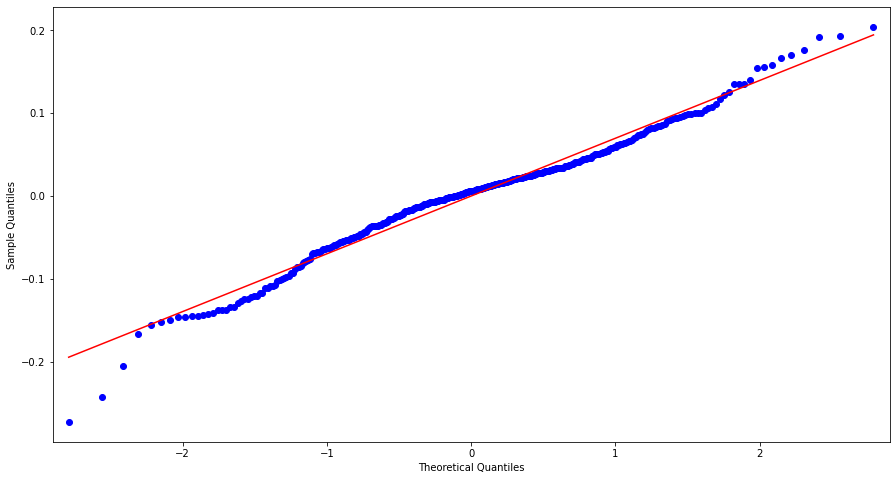

********************************************************************************
autocorrelation test
********************************************************************************

Plus petite p-value pour lors du test d'autocorrelation: 0.0 < 0.05
-> AUTOCORRELATION DETECTEE


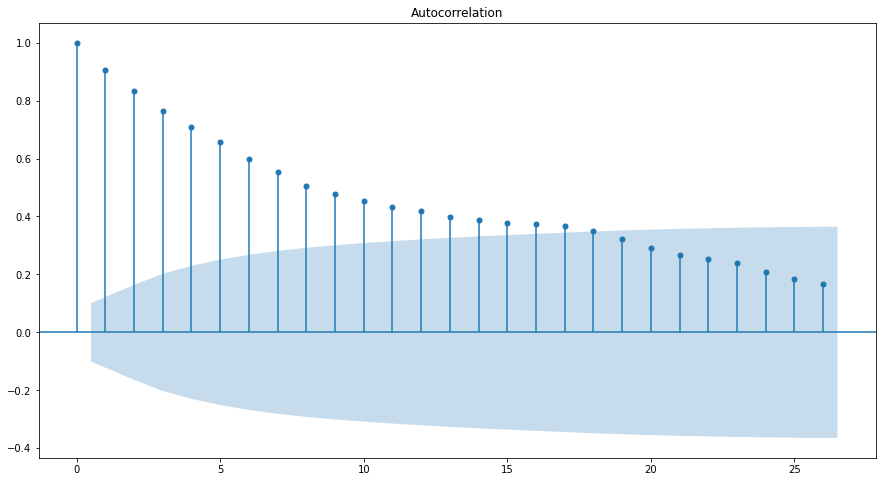


********************************************************************************
Breusch-Pagan's Test
********************************************************************************
p-value: 4.549e-25 < 0.05
HETEROSCEDACITE DETECTEE



CORRECTIONS APPORTÉES AU DATAFRAME D'ANALYSE
--------------------------------------------------------------------------------
Attention ! Avant le processus de regression multiple, le data frame d'analyse a du être modifié :


CORRECTION 1 : MULTICOLINEARITE DETECTEE DANS LES VARIABLES EXPLICATIVES
SUPPRESSION DE 12 VARIABLES
	U.S. Dollars to Euro Spot Exchange Rate- supprimé
	Wilshire 5000 Full Cap Price Index- supprimé
	Job Postings on Indeed in Spokane-Spokane Valley, WA (MSA)- supprimé
	Job Postings on Indeed in Akron, OH (MSA)- supprimé
	Job Postings on Indeed in Albuquerque, NM (MSA)- supprimé
	Crude Oil Prices: Brent - Europe- supprimé
	Crude Oil Prices: West Texas Intermediate (WTI) - Cushing, Oklahoma- supprimé
	Swiss Francs to U.S. Dollar Spo

(2, 0.9295444110429439)

In [211]:
mod_score_dict = {}

print("Test des différents modèles générés:\n")
for i, dict_var in enumerate(dict_var_indep_liste):
    reponse, r = processus_modele_regression(dict_var, direction)
    mod_score_dict[i] = (reponse, r)
    print(f"\t{i + 1} modele(s) teste(s) \tScore du modèle -> {reponse}/4")
    processus_modele_regression(var_indep_dict, direction)
    
highest_mod_score = 0
highest_r2 = 0

for i, (score1, score2) in mod_score_dict.items():
    if score1 >= highest_mod_score :
        highest_mod_score = score1

for i, (score1, score2) in mod_score_dict.items():
    if score1 >= highest_mod_score and score2 > highest_r2:
        selected_index = i
        highest_r2 = score2

print()
print(f"Avec un score de {highest_mod_score}/4 et un r2 de {highest_r2:.2f}, le modèle {selected_index + 1} semble être le mieux adapté")
print("\n")
print("Résultats du modèle: ".upper())
print("-"*80)
processus_modele_regression(dict_var_indep_liste[selected_index], direction, description_modeles=True)



_____________
_____________

# Apprentissages

### Gestion de projets

Coordoner une équipe: Puisque la plupart de notre communication s'est faite par l'intermédiaire de messenger, nous avons du fréquemment rester informés sur la progression du projet. Un membre de l'équipe gardait la version officielle et s'assurait que tout marchait avant de renvoyer à ses coéquipiers pour qu'ils puissent être tenus au courant.

### Librairies

Numpy: Pour les opérations de matrices pour la question principales, Pour créer un range de rendement pour la première question secondaire, pour supprimer les valeurs extrèmes pour la troisième question secondaire

Matplotlib: Pyplot pour la courbe efficiente, le graphique de cours du portefeuille et de l'index, et le graphique d'autocorrelation

Scikit learn: Pour gérer un modèle de régression multiple

Statsmodel: Pour faire des tests statistiques sur le modèle de régression multiple

Xlsxwriter: Pour générer des rapports formattés sur Excel pour s'assurer que les résultats ne soient perdu dans le kernel

Yfinance: Pour télécharger les actions sur le site web de yahoo finance

pandas_datareader: Pour aller chercher des données via le API de la Fred

Beautiful soup: Pour extraire du HTML et aller chercher une valeur précise (un taux de rendement sans risque)

### Sur la finance et notre portefeuille

Généralement nos portefeuilles tendent à avoir un alpha positif (c-à-d : notre stratégie est performante relativement à son industrie). En contrepartie notre portefeuille tend à avoir un ratio Sharpe supérieur à 1 seulement lorsque nous avons choisi des industrie spécifiques qui ont une meilleur performance que l'économie. Finalement sans surprise notre analyse statistique vient prouvent qu'en effet l'économie a un grande causalité sur notre portefeuille r^2 = 0.95

### Ce qu'on aurait fais de plus

1. Pouvoir séléctionner les actions désirés sur Python directement
2. Pouvoir activer ou non une contrainte limitant les ventes à découvert
3. Explorer la possibilité de créer un portfeuille qui se diversifie dans plusieurs industries
4. Utiliser pyplot pour présenter un graphique du cours de l'action plus intéractif
5. Utiliser tensorflow pour pouvoir créer un modèle de machine learning plus précis que le modèle statistique
6. Fournir à l'utilisateurs la possibilité de prédire la valeur du portfolio à l'aide des variables indépendantes du modèle statistique

In [212]:
# Surplus

In [217]:
# Amélioration possible!

# Actuellement, les variables explicatives qui sont extraites de la base de données FRED ont été choisie par nos soins. 
# Cependant, il serait possible d'utiliser une liste de variable explicatives généré automatiquement. 
# Cette dernière est crée grâce au fredapi. Comme on peut le voir, la variable "gen_list_id",  extrait une liste de 
# toutes les variable explicatives qui correspond à certains critères de recherche.


api_key='c9fa6f012c9ea24190b41703d64f6d08'

tag_names="daily"
exclude_tag_names=""
order_by=""
limit=""

response = requests.get(f'https://api.stlouisfed.org/fred/tags/series?tag_names={tag_names}&api_key={api_key}&file_type=json')
data = json.loads(response.text)

fred_series = data['seriess']
gen_list_id = []
gen_list_title = []


for fred_dict in fred_series:
    gen_list_id.append(fred_dict['id'])
    gen_list_title.append(fred_dict['title'])

print("Les id des series à importer sont")
print(gen_list_id)

# Pour que cet extracteur de valeur aie une valeur ajouté nous aurions du avoir des processus avancés et des
# connaissances plus profonde en finance et en économie, dans son état actuel ce processus est inférieur à
# celui que nous avons utilisé

Les id des series à importer sont
['4BIGEURORECD', '4BIGEURORECDM', '4BIGEURORECDP', 'AAA10Y', 'AAAFF', 'AB1020AAAMT', 'AB1020AAVOL', 'AB14AAAMT', 'AB14AAVOL', 'AB2140AAAMT', 'AB2140AAVOL', 'AB4180AAAMT', 'AB4180AAVOL', 'AB59AAAMT', 'AB59AAVOL', 'ABGT80AAAMT', 'ABGT80AAVOL', 'ABSSD678FRBCLE', 'AMBOR1M', 'AMBOR1W', 'AMBOR1Y', 'AMBOR2Y', 'AMBOR30', 'AMBOR3M', 'AMBOR6M', 'AMBOR90', 'AMERIBOR', 'AUINTDDL', 'AUINTDGT', 'AUSRECD', 'AUSRECDM', 'AUSRECDP', 'AUTRECD', 'AUTRECDM', 'AUTRECDP', 'BAA10Y', 'BAAFF', 'BAMLC0A0CM', 'BAMLC0A0CMEY', 'BAMLC0A0CMSYTW', 'BAMLC0A1CAAA', 'BAMLC0A1CAAAEY', 'BAMLC0A1CAAASYTW', 'BAMLC0A2CAA', 'BAMLC0A2CAAEY', 'BAMLC0A2CAASYTW', 'BAMLC0A3CA', 'BAMLC0A3CAEY', 'BAMLC0A3CASYTW', 'BAMLC0A4CBBB', 'BAMLC0A4CBBBEY', 'BAMLC0A4CBBBSYTW', 'BAMLC1A0C13Y', 'BAMLC1A0C13YEY', 'BAMLC1A0C13YSYTW', 'BAMLC2A0C35Y', 'BAMLC2A0C35YEY', 'BAMLC2A0C35YSYTW', 'BAMLC3A0C57Y', 'BAMLC3A0C57YEY', 'BAMLC3A0C57YSYTW', 'BAMLC4A0C710Y', 'BAMLC4A0C710YEY', 'BAMLC4A0C710YSYTW', 'BAMLC7A0C1015Y', '